In [ ]:
import os
import pandas as pd
import numpy as np
from deepface import DeepFace
import tensorflow as tf
from PIL import Image


# ---------- Utility Functions ----------
def load_and_preprocess(image_path, input_size):
    img = Image.open(image_path).convert('RGB').resize(input_size)
    arr = np.array(img).astype('float32') / 255.0
    return (arr - 0.5) * 2

def compute_embedding(model, image_tensor):
    if isinstance(model, tf.keras.Model):
        return tf.nn.l2_normalize(model(image_tensor, training=False), axis=1)
    else:
        return tf.nn.l2_normalize(tf.convert_to_tensor(model.predict(image_tensor.numpy())), axis=1)

def load_embedding(image_path, model, input_size):
    img_tensor = tf.expand_dims(load_and_preprocess(image_path, input_size), 0)
    return compute_embedding(model, img_tensor)

def cosine_similarity(emb1, emb2):
    emb1 = tf.nn.l2_normalize(emb1, axis=-1)
    emb2 = tf.nn.l2_normalize(emb2, axis=-1)
    cos_sim = tf.reduce_sum(emb1 * emb2).numpy()
    return float((cos_sim + 1.0) / 2.0)

def extract_embedding_with_represent(img_path, model_name):
    try:
        rep = DeepFace.represent(img_path=img_path, model_name=model_name, enforce_detection=False)
        if isinstance(rep, list):
            return np.array(rep[0]["embedding"])
        return np.array(rep["embedding"])
    except Exception as e:
        print(f"Error extracting embedding with {model_name}: {e}")
        return None

def get_adv_image_path(base_path, img1_path, img2_path, attack_type, adv_model):
    """Construct the path to adversarial image based on the folder structure"""
    img1_name = os.path.splitext(os.path.basename(img1_path))[0]
    img2_name = os.path.splitext(os.path.basename(img2_path))[0]
    filename = f"adv_{img1_name}_to_{img2_name}_{attack_type}.png"
    return os.path.join(base_path, adv_model, filename)

# ---------- Model Config ----------
model_input_sizes = {
    "VGG-Face": (224, 224),
    "Facenet": (160, 160),
    "Facenet512": (160, 160),
    "ArcFace": (112, 112),
    "GhostFaceNet": (112, 112),
}

# ---------- Input and Output ----------
input_path = "input_pairs_with_adv_paths.csv"
dataset_base = "/content/drive/MyDrive"
adv_images_base = "/content/drive/MyDrive/adv_images"
output_path = "transfer_attack_results_sample.csv"
# Read input CSV


# Then proceed with your existing code...
# Load models (excluding Dlib, SFace, and buffalo_s)
print("Loading face recognition models...")
models = {}
for model_name in model_input_sizes:
    print(f"Loading model: {model_name}")
    try:
        models[model_name] = DeepFace.build_model(model_name).model
    except Exception as e:
        print(f"Error loading {model_name}: {e}")
        models[model_name] = None

# Read input CSV
df = pd.read_csv(input_path)

# Clean paths by removing leading ../../
df["img1"] = df["img1"].str.replace(r"^\.\./\.\./", "", regex=True)
df["img2"] = df["img2"].str.replace(r"^\.\./\.\./", "", regex=True)

# Then proceed with your existing code...
# Select first 20 and last 20 rows
sample_df = pd.concat([df.head(20), df.tail(20)])

# Initialize results dictionary
results = {
    "img1": [],
    "img2": [],
    "dataset": [],
    "attack_type": [],
}

# Add columns for each model's clean and adversarial scores
models_to_test = ["VGG-Face", "Facenet", "Facenet512", "ArcFace", "GhostFaceNet"]
adv_models = ["Facenet", "Facenet512", "GhostFaceNet", "ArcFace", "VGG-Face"]

for model_name in models_to_test:
    # Clean score column
    results[f"{model_name}_clean"] = []

    # Adversarial score columns
    for adv_model in adv_models:
        results[f"{model_name}_{adv_model}_adv"] = []

# ---------- Process Each Image Pair ----------
for idx, row in sample_df.iterrows():
    # Construct correct paths for original images
    img1_path = os.path.join(dataset_base, row["img1"])
    img2_path = os.path.join(dataset_base, row["img2"])
    dataset = row["dataset"]
    attack_type = row["attack_type"]

    # Add basic info to results
    results["img1"].append(img1_path)
    results["img2"].append(img2_path)
    results["dataset"].append(dataset)
    results["attack_type"].append(attack_type)

    # Check if original images exist
    if not (os.path.exists(img1_path) and os.path.exists(img2_path)):
        print(f"Missing original image(s) at row {idx}: {img1_path}, {img2_path}")
        # Fill with NaN for all model scores
        for model_name in models_to_test:
            results[f"{model_name}_clean"].append(np.nan)
            for adv_model in adv_models:
                results[f"{model_name}_{adv_model}_adv"].append(np.nan)
        continue

    # Process each model for clean similarity
    for model_name in models_to_test:
        model = models[model_name]
        if model is None:
            results[f"{model_name}_clean"].append(np.nan)
            for adv_model in adv_models:
                results[f"{model_name}_{adv_model}_adv"].append(np.nan)
            continue

        try:
            # Calculate clean similarity
            emb1 = load_embedding(img1_path, model, model_input_sizes[model_name])
            emb2 = load_embedding(img2_path, model, model_input_sizes[model_name])
            clean_sim = cosine_similarity(emb1, emb2)

            results[f"{model_name}_clean"].append(clean_sim)

            # Calculate adversarial similarities
            for adv_model in adv_models:
                adv_path = get_adv_image_path(adv_images_base, img1_path, img2_path, attack_type, adv_model)

                if not os.path.exists(adv_path):
                    print(f"Missing adversarial image at row {idx}: {adv_path}")
                    results[f"{model_name}_{adv_model}_adv"].append(np.nan)
                    continue

                try:
                    adv_emb = load_embedding(adv_path, model, model_input_sizes[model_name])
                    emb2 = load_embedding(img2_path, model, model_input_sizes[model_name])
                    adv_sim = cosine_similarity(adv_emb, emb2)

                    results[f"{model_name}_{adv_model}_adv"].append(adv_sim)
                except Exception as e:
                    print(f"Error processing adversarial {adv_model} with {model_name} at row {idx}: {e}")
                    results[f"{model_name}_{adv_model}_adv"].append(np.nan)

            print(f"Row {idx}, Model {model_name}: Clean similarity = {clean_sim:.4f}")

        except Exception as e:
            print(f"Error processing {model_name} at row {idx}: {e}")
            results[f"{model_name}_clean"].append(np.nan)
            for adv_model in adv_models:
                results[f"{model_name}_{adv_model}_adv"].append(np.nan)

# ---------- Save Output ----------
output_df = pd.DataFrame(results)
output_df.to_csv(output_path, index=False)
print(f"Saved {output_path} with {len(output_df)} rows")
print("Processing complete!")

Loading face recognition models...
Loading model: VGG-Face
Loading model: Facenet
Loading model: Facenet512
Loading model: ArcFace
Loading model: GhostFaceNet
Row 0, Model VGG-Face: Clean similarity = 0.9397
Row 0, Model Facenet: Clean similarity = 0.9784
Row 0, Model Facenet512: Clean similarity = 0.9884
Row 0, Model ArcFace: Clean similarity = 0.9455
Row 0, Model GhostFaceNet: Clean similarity = 0.9448
Row 1, Model VGG-Face: Clean similarity = 0.9067
Row 1, Model Facenet: Clean similarity = 0.9640
Row 1, Model Facenet512: Clean similarity = 0.9623
Row 1, Model ArcFace: Clean similarity = 0.9241
Row 1, Model GhostFaceNet: Clean similarity = 0.9309
Row 2, Model VGG-Face: Clean similarity = 0.9596
Row 2, Model Facenet: Clean similarity = 0.9841
Row 2, Model Facenet512: Clean similarity = 0.9765
Row 2, Model ArcFace: Clean similarity = 0.9203
Row 2, Model GhostFaceNet: Clean similarity = 0.9245
Row 3, Model VGG-Face: Clean similarity = 0.9207
Row 3, Model Facenet: Clean similarity = 0.97

25-06-05 16:01:13 - Directory /root/.deepface has been created
25-06-05 16:01:13 - Directory /root/.deepface/weights has been created


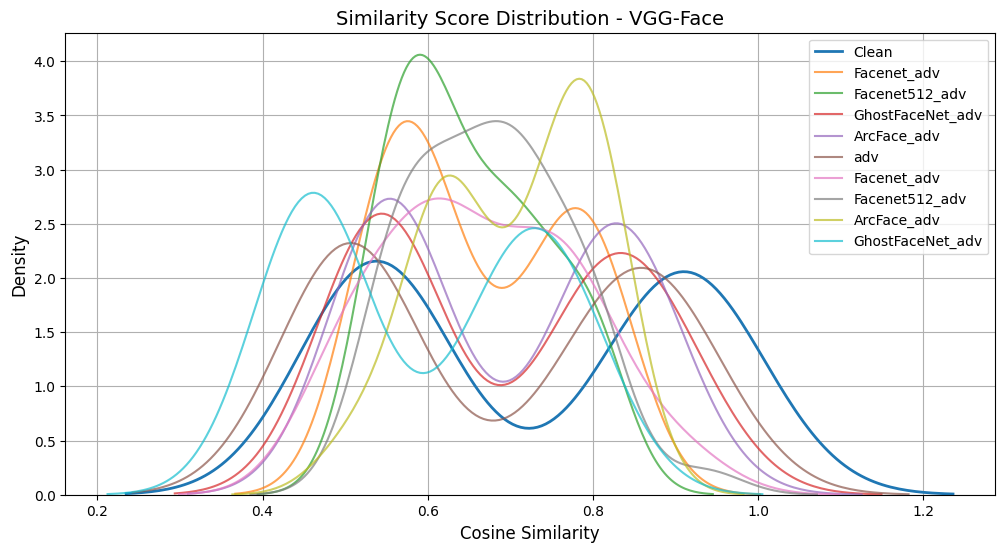

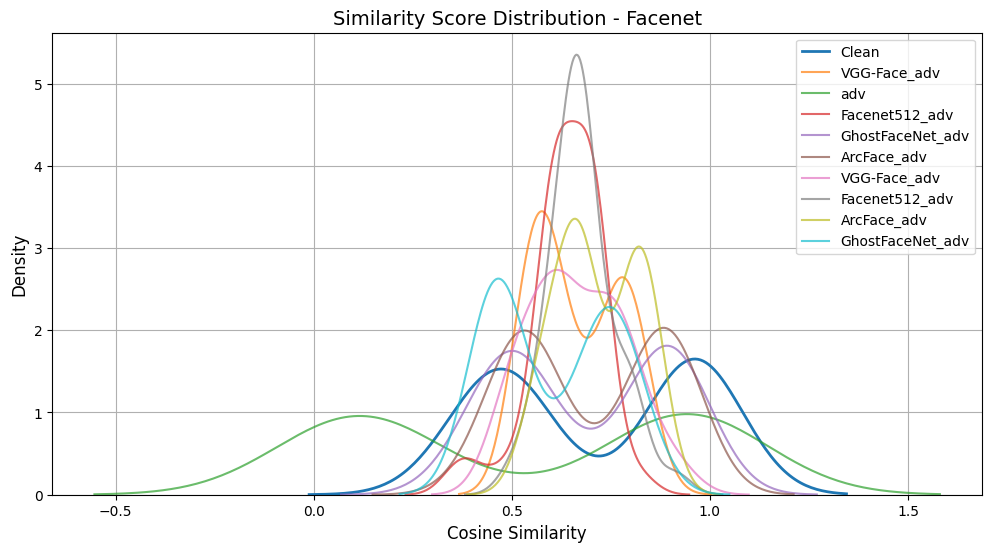

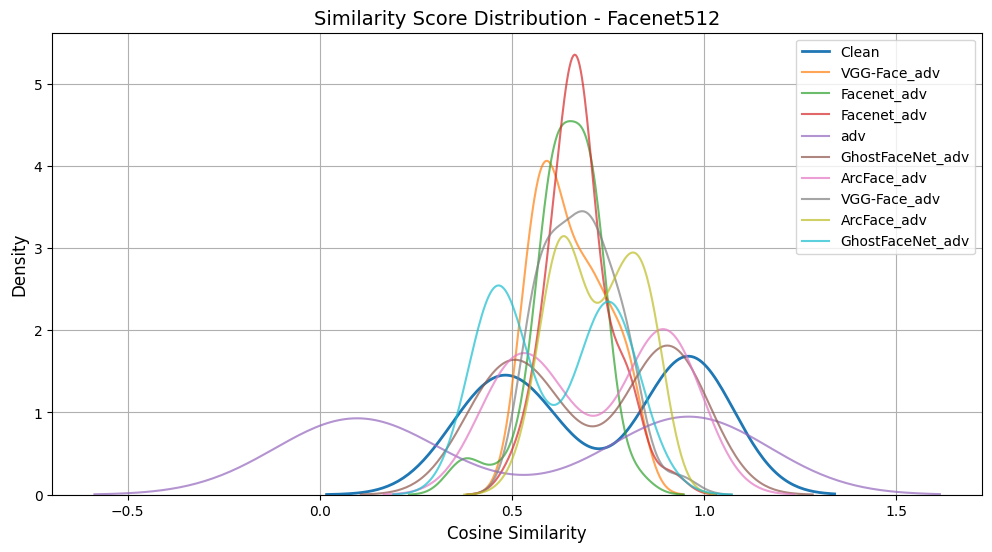

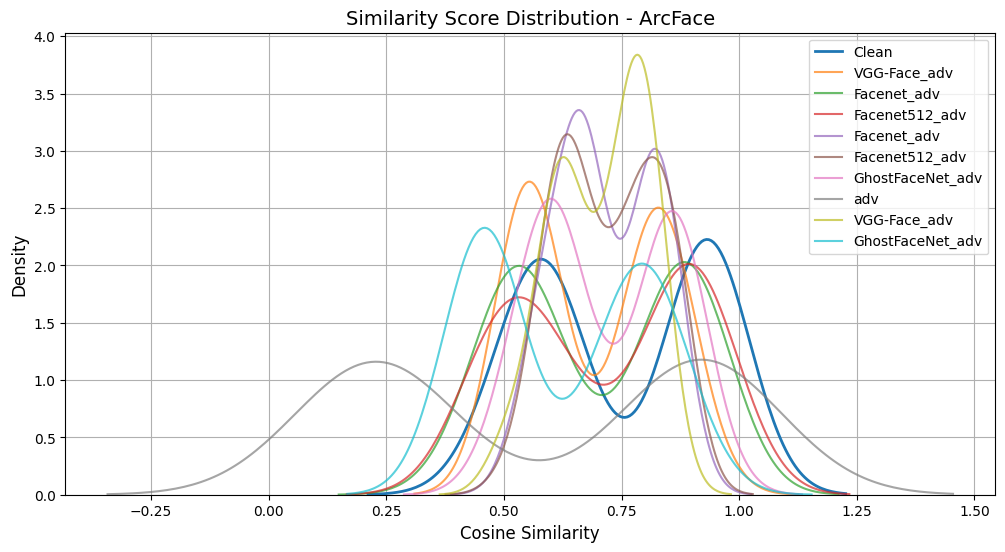

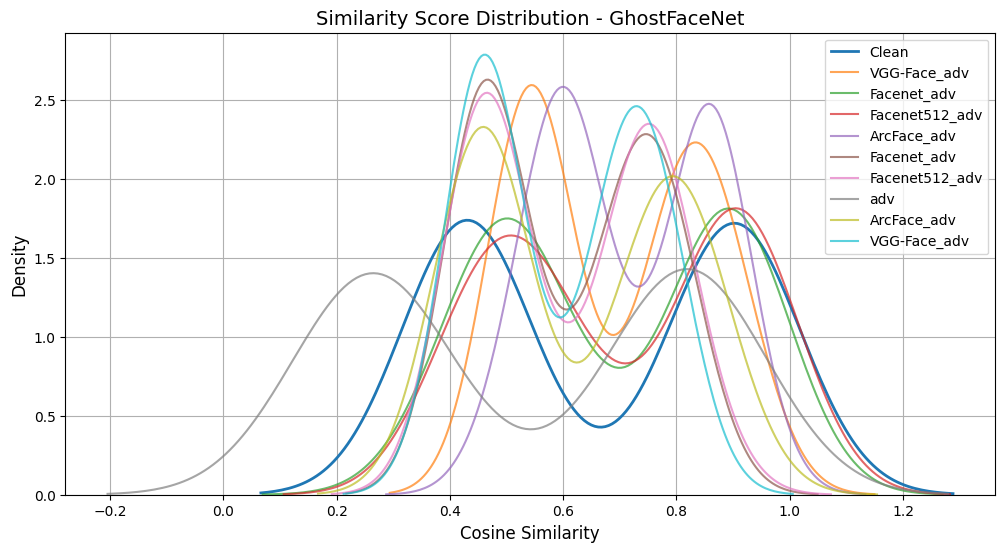

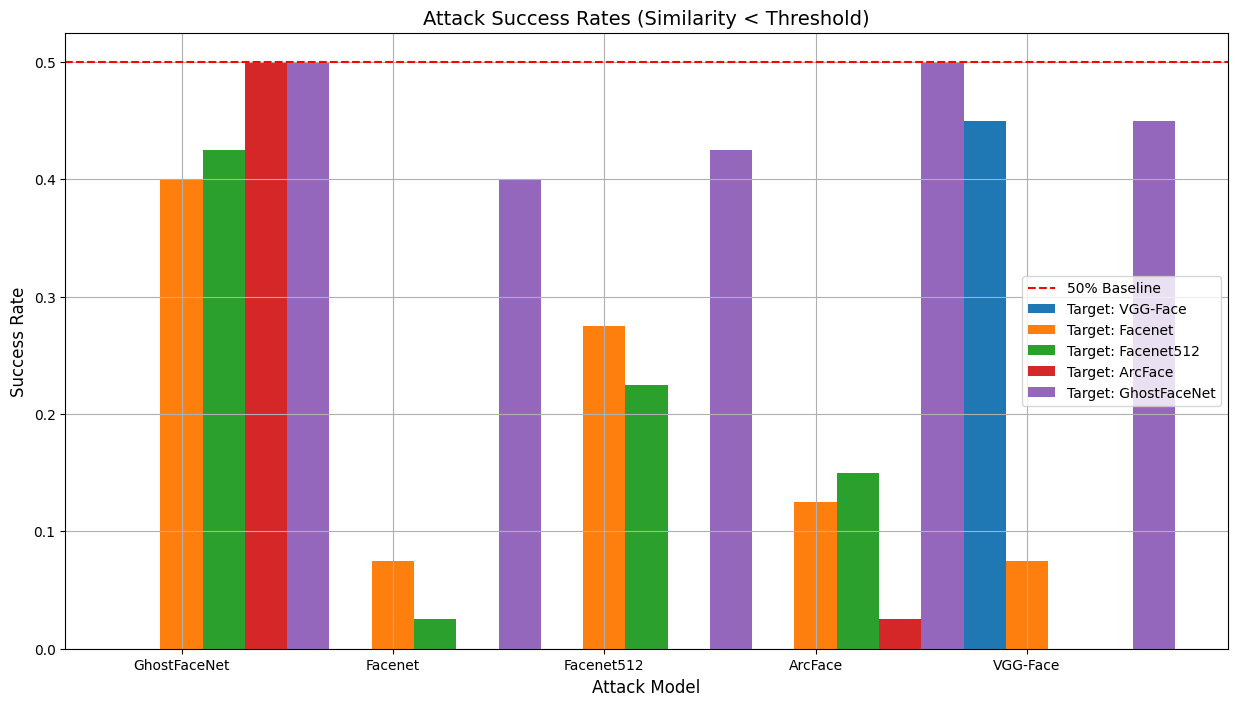

NameError: name 'models' is not defined

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from deepface import DeepFace
import tensorflow as tf
from tensorflow.keras import Model
from tqdm import tqdm

# ---------- Visualization Functions ----------
def plot_similarity_distributions(results_df, model_name, save_path=None):
    """Plot clean vs adversarial similarity score distributions"""
    plt.figure(figsize=(12, 6))

    # Clean scores
    sns.kdeplot(results_df[f"{model_name}_clean"], label='Clean', linewidth=2)

    # Adversarial scores
    adv_columns = [col for col in results_df.columns if f"{model_name}_" in col and "adv" in col]
    for col in adv_columns:
        sns.kdeplot(results_df[col], label=col.replace(f"{model_name}_", ""), alpha=0.7)

    plt.title(f'Similarity Score Distribution - {model_name}', fontsize=14)
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(os.path.join(save_path, f'similarity_dist_{model_name}.png'))
    plt.show()

def plot_attack_success_rates(results_df, threshold=0.5, save_path=None):
    """Calculate and plot attack success rates across models"""
    models = [col.split('_')[0] for col in results_df.columns if '_clean' in col]
    success_rates = {}

    for model in models:
        clean_passed = (results_df[f"{model}_clean"] >= threshold).mean()
        adv_rates = {}

        adv_columns = [col for col in results_df.columns if f"{model}_" in col and "adv" in col]
        for col in adv_columns:
            adv_model = col.split('_')[1]
            adv_success = (results_df[col] < threshold).mean()
            adv_rates[adv_model] = adv_success

        success_rates[model] = {
            'clean_pass_rate': clean_passed,
            'attack_success': adv_rates
        }

    # Plotting
    plt.figure(figsize=(15, 8))

    for i, model in enumerate(models):
        adv_models = list(success_rates[model]['attack_success'].keys())
        rates = list(success_rates[model]['attack_success'].values())

        plt.bar(np.arange(len(adv_models)) + i*0.2, rates, width=0.2,
                label=f'Target: {model}')

    plt.xticks(np.arange(len(adv_models)) + 0.2, adv_models)
    plt.title('Attack Success Rates (Similarity < Threshold)', fontsize=14)
    plt.xlabel('Attack Model', fontsize=12)
    plt.ylabel('Success Rate', fontsize=12)
    plt.axhline(y=0.5, color='r', linestyle='--', label='50% Baseline')
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(os.path.join(save_path, 'attack_success_rates.png'))
    plt.show()

    return success_rates

# ---------- PGD Attack Extension ----------
class PGDAttack:
    def __init__(self, model, eps=0.05, alpha=0.01, steps=40, random_start=True):
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start

    def generate(self, x, y):
        """Generate PGD adversarial examples"""
        if self.random_start:
            x_adv = x + tf.random.uniform(x.shape, -self.eps, self.eps)
            x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)  # Assuming images in [-1,1]
        else:
            x_adv = tf.identity(x)

        for _ in range(self.steps):
            with tf.GradientTape() as tape:
                tape.watch(x_adv)
                emb_adv = self.model(x_adv, training=False)
                emb_target = self.model(y, training=False)
                loss = -tf.reduce_sum(emb_adv * emb_target)  # Maximize similarity

            grad = tape.gradient(loss, x_adv)
            x_adv = x_adv + self.alpha * tf.sign(grad)
            x_adv = tf.clip_by_value(x_adv, x - self.eps, x + self.eps)
            x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)

        return x_adv

def extend_pgd_attacks(models, dataset_df, input_sizes, output_dir, eps=0.03):
    """Extend PGD attacks to all specified models"""
    os.makedirs(output_dir, exist_ok=True)

    results = []
    for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df)):
        img1_path = os.path.join(dataset_base, row["img1"])
        img2_path = os.path.join(dataset_base, row["img2"])

        if not (os.path.exists(img1_path) and os.path.exists(img2_path)):
            continue

        for model_name, model in models.items():
            if model is None:
                continue

            try:
                # Load and preprocess images
                input_size = input_sizes[model_name]
                x = tf.expand_dims(load_and_preprocess(img1_path, input_size), 0)
                y = tf.expand_dims(load_and_preprocess(img2_path, input_size), 0)

                # Generate PGD attack
                attacker = PGDAttack(model, eps=eps)
                x_adv = attacker.generate(x, y)

                # Save adversarial image
                adv_img = ((x_adv[0].numpy() + 1.0) * 127.5).astype('uint8')
                adv_path = os.path.join(output_dir,
                                       f"pgd_{model_name}_{os.path.basename(img1_path)}")
                Image.fromarray(adv_img).save(adv_path)

                # Calculate similarities
                emb_clean = compute_embedding(model, x)
                emb_adv = compute_embedding(model, x_adv)
                emb_target = compute_embedding(model, y)

                clean_sim = cosine_similarity(emb_clean, emb_target)
                adv_sim = cosine_similarity(emb_adv, emb_target)

                results.append({
                    'model': model_name,
                    'image_pair': f"{os.path.basename(img1_path)}_{os.path.basename(img2_path)}",
                    'clean_similarity': clean_sim,
                    'adv_similarity': adv_sim,
                    'similarity_drop': clean_sim - adv_sim,
                    'adv_path': adv_path
                })

            except Exception as e:
                print(f"Error processing {model_name} on {img1_path}: {str(e)}")

    return pd.DataFrame(results)

# ---------- Main Execution ----------
if __name__ == "__main__":
    # Load your results dataframe
    results_df = pd.read_csv("transfer_attack_results_sample.csv")

    # 1. Visualize effectiveness
    output_dir = "/content/drive/MyDrive/attack_visualizations"
    os.makedirs(output_dir, exist_ok=True)

    for model in ["VGG-Face", "Facenet", "Facenet512", "ArcFace", "GhostFaceNet"]:
        plot_similarity_distributions(results_df, model, output_dir)

    success_rates = plot_attack_success_rates(results_df, threshold=0.5, save_path=output_dir)

    # 2. Extend PGD attacks
    pgd_results = extend_pgd_attacks(
        models=models,
        dataset_df=sample_df,
        input_sizes=model_input_sizes,
        output_dir="/content/drive/MyDrive/pgd_adv_images",
        eps=0.04
    )

    # Save PGD results
    pgd_results.to_csv("/content/drive/MyDrive/pgd_attack_results.csv", index=False)

Visualizing existing attack results...


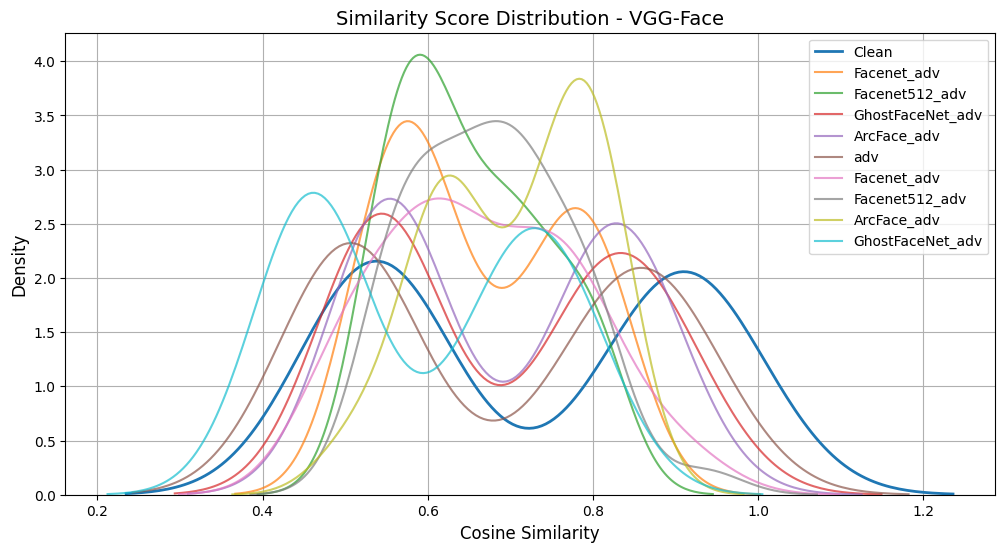

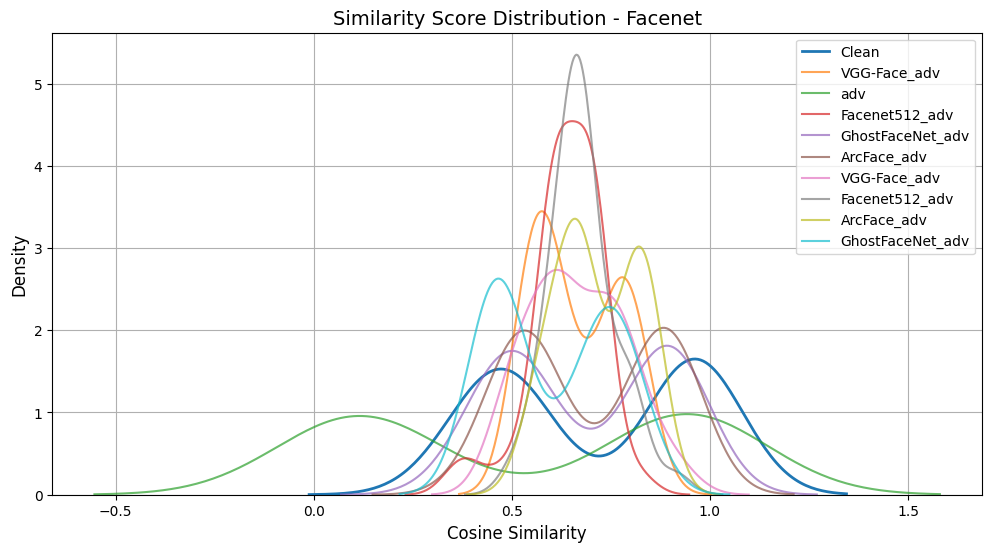

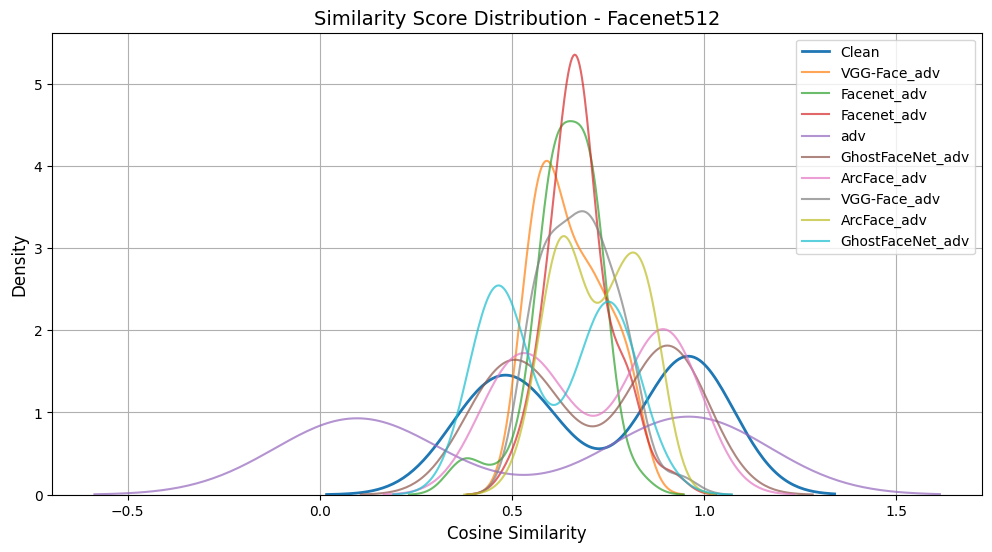

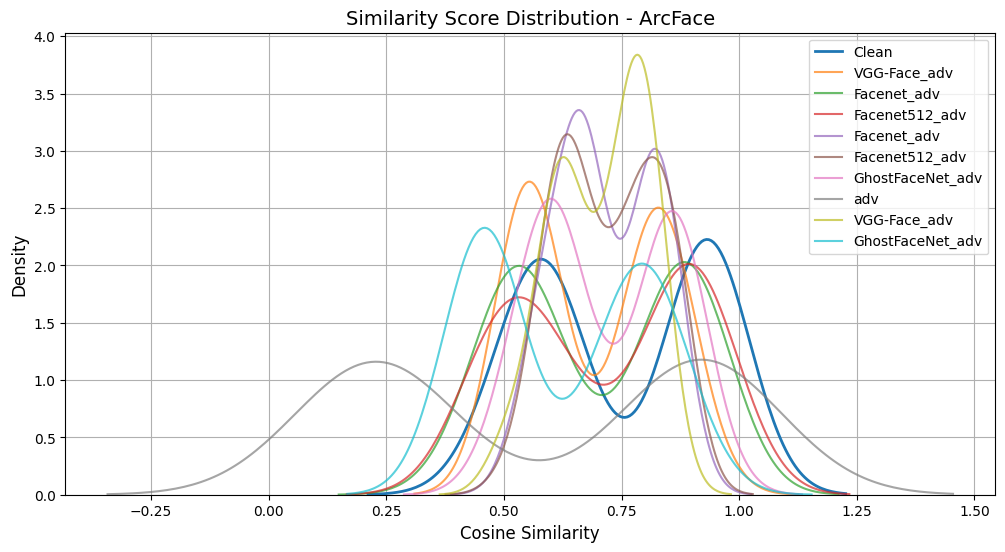

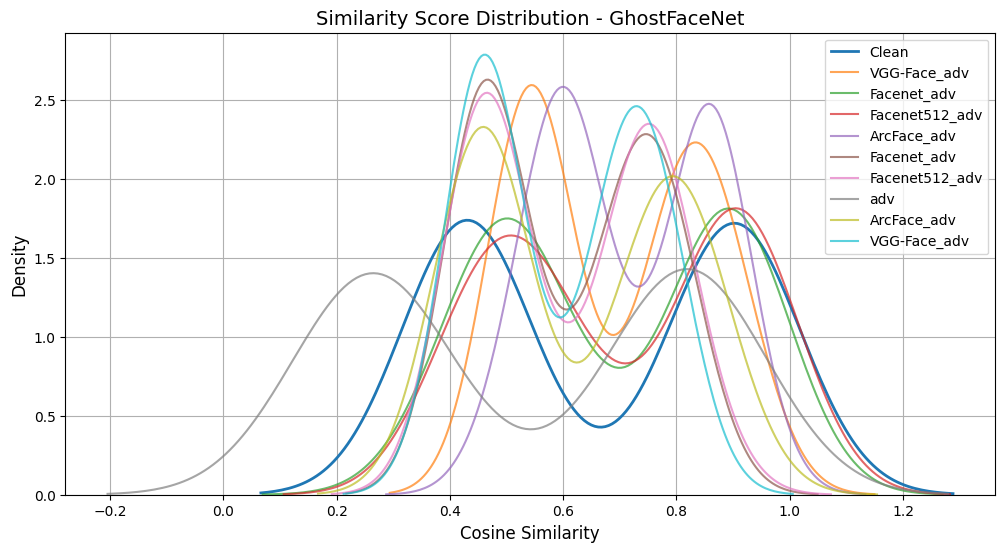

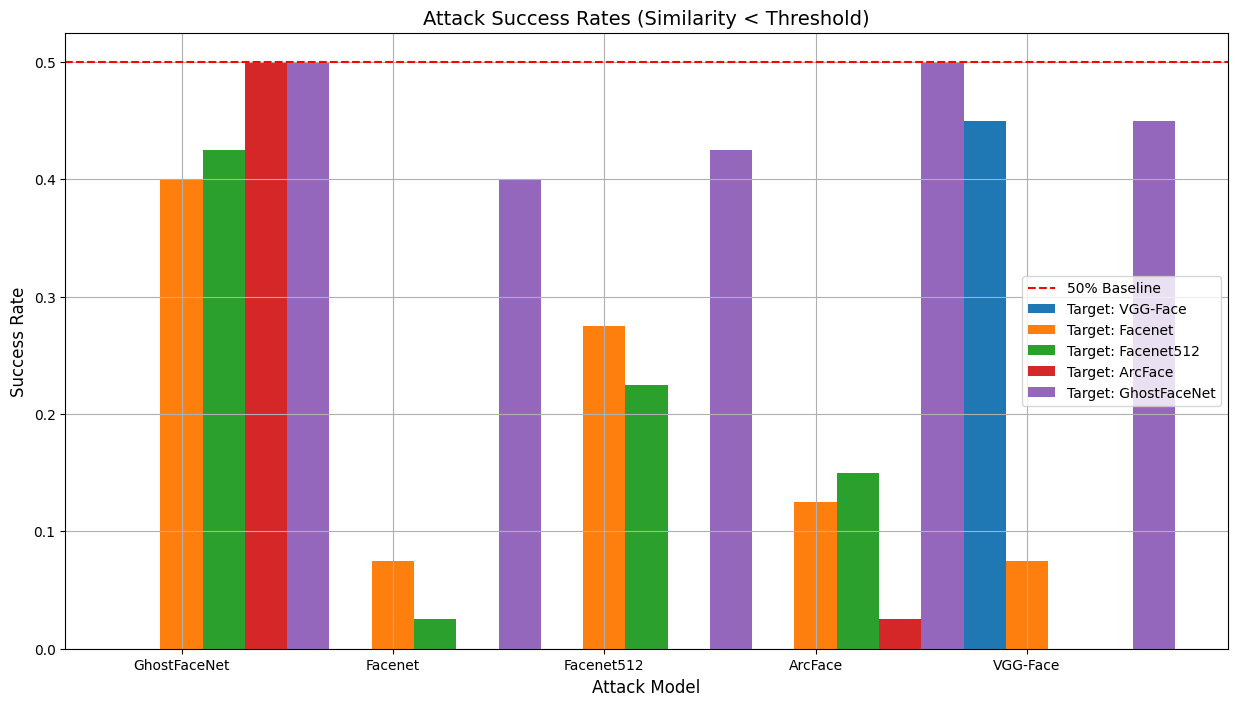


Running PGD attacks on all models...

Running PGD attacks for VGG-Face...


100%|██████████| 40/40 [00:00<00:00, 4310.69it/s]



Running PGD attacks for Facenet...


100%|██████████| 40/40 [00:00<00:00, 4938.11it/s]



Running PGD attacks for Facenet512...


100%|██████████| 40/40 [00:00<00:00, 4711.51it/s]



Running PGD attacks for ArcFace...


100%|██████████| 40/40 [00:00<00:00, 5375.59it/s]



Running PGD attacks for GhostFaceNet...


100%|██████████| 40/40 [00:00<00:00, 5348.00it/s]


PGD attack results saved to: /content/drive/MyDrive/attack_analysis/pgd_attack_results.csv

Visualizing PGD attack results...
No PGD results to visualize

Analysis complete! All results saved to: /content/drive/MyDrive/attack_analysis


In [ ]:
# ---------- Main Execution ----------
if __name__ == "__main__":
    # 1. Load your dataset and results
    input_path = "input_pairs_with_adv_paths.csv"
    results_path = "transfer_attack_results_sample.csv"

    df = pd.read_csv(input_path)
    sample_df = pd.concat([df.head(20), df.tail(20)])  # Or use your full dataset
    results_df = pd.read_csv(results_path)

    # 2. Visualize existing results - MODIFIED TO MATCH YOUR CSV STRUCTURE
    print("Visualizing existing attack results...")
    target_models = ["VGG-Face", "Facenet", "Facenet512", "ArcFace", "GhostFaceNet"]
    attack_models = ["VGG-Face", "Facenet", "Facenet512", "ArcFace", "GhostFaceNet"]

    for model in target_models:
        # Check if this model has columns in the results
        if f"{model}_clean" in results_df.columns:
            plot_similarity_distributions(results_df, model, output_dir)

    success_rates = plot_attack_success_rates(results_df, threshold=0.5, save_path=output_dir)

    # 3. Run PGD attacks on all models - THIS CREATES NEW RESULTS WITH DIFFERENT STRUCTURE
    print("\nRunning PGD attacks on all models...")
    pgd_results = []
    for model_name, model in models.items():
        if model is None:
            continue

        print(f"\nRunning PGD attacks for {model_name}...")
        attacker = PGDAttack(model, eps=0.03, steps=30)

        for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
            try:
                img1_path = os.path.join(dataset_base, row["img1"])
                img2_path = os.path.join(dataset_base, row["img2"])

                if not (os.path.exists(img1_path) and os.path.exists(img2_path)):
                    continue

                # Load and preprocess images
                input_size = model_input_sizes[model_name]
                x = tf.expand_dims(load_and_preprocess(img1_path, input_size), 0)
                y = tf.expand_dims(load_and_preprocess(img2_path, input_size), 0)

                # Generate attack
                x_adv = attacker.generate(x, y)

                # Compute similarities
                emb_clean = compute_embedding(model, x)
                emb_adv = compute_embedding(model, x_adv)
                emb_target = compute_embedding(model, y)

                clean_sim = cosine_similarity(emb_clean, emb_target)
                adv_sim = cosine_similarity(emb_adv, emb_target)

                pgd_results.append({
                    'attack_model': model_name,  # Changed from 'model' to be explicit
                    'image_pair': f"{os.path.basename(img1_path)}_{os.path.basename(img2_path)}",
                    'clean_similarity': clean_sim,
                    'adv_similarity': adv_sim,
                    'similarity_drop': clean_sim - adv_sim
                })

            except Exception as e:
                print(f"Error processing {model_name} on row {idx}: {e}")

    # Save PGD results - THESE WILL HAVE DIFFERENT COLUMNS THAN ORIGINAL RESULTS
    pgd_results_df = pd.DataFrame(pgd_results)
    pgd_results_path = os.path.join(output_dir, "pgd_attack_results.csv")
    pgd_results_df.to_csv(pgd_results_path, index=False)
    print(f"\nPGD attack results saved to: {pgd_results_path}")

    # 4. Visualize PGD results - MODIFIED FOR NEW STRUCTURE
    print("\nVisualizing PGD attack results...")
    if not pgd_results_df.empty and 'attack_model' in pgd_results_df.columns:
        for model_name in pgd_results_df['attack_model'].unique():
            model_results = pgd_results_df[pgd_results_df['attack_model'] == model_name]

            plt.figure(figsize=(10, 5))
            sns.kdeplot(model_results['clean_similarity'], label='Clean')
            sns.kdeplot(model_results['adv_similarity'], label='Adversarial')
            plt.title(f'PGD Attack Effectiveness - {model_name}')
            plt.xlabel('Similarity Score')
            plt.ylabel('Density')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(output_dir, f'pgd_effectiveness_{model_name}.png'))
            plt.show()
    else:
        print("No PGD results to visualize")

    print("\nAnalysis complete! All results saved to:", output_dir)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load your data
df = pd.read_csv("transfer_attack_results_sample.csv")

# Define the models and attack types
target_models = ["VGG-Face", "Facenet", "Facenet512", "ArcFace", "GhostFaceNet"]
attack_models = ["VGG-Face", "Facenet", "Facenet512", "ArcFace", "GhostFaceNet"]
datasets = df['dataset'].unique()
attack_types = df['attack_type'].unique()

# Create output directory
output_dir = "attack_heatmaps"
os.makedirs(output_dir, exist_ok=True)

def calculate_accuracy_drop(clean_scores, adv_scores):
    """Calculate accuracy drop percentage (higher drop = more successful attack)"""
    return (clean_scores - adv_scores).mean() * 100

def create_heatmap_data(df, dataset_filter=None, attack_filter=None):
    """Prepare data for heatmap visualization"""
    heatmap_data = []

    # Filter data if needed
    filtered_df = df.copy()
    if dataset_filter:
        filtered_df = filtered_df[filtered_df['dataset'] == dataset_filter]
    if attack_filter:
        filtered_df = filtered_df[filtered_df['attack_type'] == attack_filter]

    for target in target_models:
        row_data = {'Target Model': target}
        clean_col = f"{target}_clean"

        for attack in attack_models:
            if target == attack:
                # Skip when target and attack model are the same
                row_data[attack] = np.nan
                continue

            adv_col = f"{target}_{attack}_adv"

            if clean_col in df.columns and adv_col in df.columns:
                accuracy_drop = calculate_accuracy_drop(
                    filtered_df[clean_col],
                    filtered_df[adv_col]
                )
                row_data[attack] = accuracy_drop
            else:
                row_data[attack] = np.nan

        heatmap_data.append(row_data)

    return pd.DataFrame(heatmap_data).set_index('Target Model')

def plot_heatmap(data, title, filename):
    """Generate and save a heatmap visualization"""
    plt.figure(figsize=(12, 8))
    sns.heatmap(data, annot=True, fmt=".1f", cmap="YlOrRd",
                linewidths=0.5, cbar_kws={'label': 'Accuracy Drop (%)'},
                vmin=0, vmax=100)

    plt.title(title, pad=20, fontsize=14)
    plt.xlabel("Attack Source Model", fontsize=12)
    plt.ylabel("Target Model", fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save with high DPI
    plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches="tight")
    plt.close()

# Generate heatmaps for each dataset and attack type combination
for dataset in datasets:
    for attack_type in attack_types:
        # Create dataset-specific heatmap data
        heatmap_df = create_heatmap_data(df, dataset, attack_type)

        # Generate and save heatmap
        title = f"Attack Effectiveness\nDataset: {dataset} | Attack: {attack_type}"
        filename = f"heatmap_{dataset}_{attack_type}.png"
        plot_heatmap(heatmap_df, title, filename)

# Create overall heatmap (all data combined)
overall_heatmap = create_heatmap_data(df)
plot_heatmap(overall_heatmap,
             "Overall Attack Effectiveness Across All Datasets",
             "heatmap_overall.png")

print(f"Heatmap generation complete! Results saved to: {output_dir}")

Heatmap generation complete! Results saved to: attack_heatmaps


In [2]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=867763ed6f96e8854c1eb26e32cb0f5b9b487086a8b985f88335f2372068b6a4
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from deepface import DeepFace
from PIL import Image
from tqdm import tqdm

# Configuration
dataset_base = "/content/drive/MyDrive/dataset_extractedfaces"
output_dir = "/content/drive/MyDrive/adv_images"
os.makedirs(output_dir, exist_ok=True)

# Model setup with input sizes
model_config = {
    "VGG-Face": {"input_size": (224, 224)},
    "Facenet": {"input_size": (160, 160)},
    "Facenet512": {"input_size": (160, 160)},
    "ArcFace": {"input_size": (112, 112)},
    "GhostFaceNet": {"input_size": (112, 112)},
    # Add other models you want to test
}

# Initialize models
print("Loading face recognition models...")
for model_name in model_config:
    try:
        model_config[model_name]["model"] = DeepFace.build_model(model_name).model
        print(f"Successfully loaded {model_name}")
    except Exception as e:
        print(f"Error loading {model_name}: {str(e)}")
        model_config[model_name]["model"] = None

# Helper functions
def load_and_preprocess(image_path, input_size):
    """Load and preprocess image for model input"""
    img = Image.open(image_path).convert('RGB').resize(input_size)
    arr = np.array(img).astype('float32') / 255.0
    return (arr - 0.5) * 2  # Scale to [-1, 1]

def compute_embedding(model, image_tensor):
    """Compute normalized embedding"""
    if isinstance(model, tf.keras.Model):
        return tf.nn.l2_normalize(model(image_tensor, training=False), axis=1)
    return tf.nn.l2_normalize(tf.convert_to_tensor(model.predict(image_tensor.numpy())), axis=1)

def cosine_similarity(emb1, emb2):
    """Compute cosine similarity between embeddings"""
    emb1 = tf.nn.l2_normalize(emb1, axis=-1)
    emb2 = tf.nn.l2_normalize(emb2, axis=-1)
    return float((tf.reduce_sum(emb1 * emb2).numpy() + 1.0)) / 2.0  # Scale to [0, 1]

# PGD Attack Class
class PGDAttack:
    def __init__(self, model, eps=0.03, alpha=0.01, steps=40, random_start=True):
        self.model = model
        self.eps = eps  # Attack strength
        self.alpha = alpha  # Step size
        self.steps = steps  # Number of iterations
        self.random_start = random_start

    def generate(self, x, y):
        """Generate PGD adversarial examples"""
        if self.random_start:
            x_adv = x + tf.random.uniform(x.shape, -self.eps, self.eps)
            x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)
        else:
            x_adv = tf.identity(x)

        for _ in range(self.steps):
            with tf.GradientTape() as tape:
                tape.watch(x_adv)
                emb_adv = self.model(x_adv, training=False)
                emb_target = self.model(y, training=False)
                loss = -tf.reduce_sum(emb_adv * emb_target)  # Maximize similarity

            grad = tape.gradient(loss, x_adv)
            x_adv = x_adv + self.alpha * tf.sign(grad)
            x_adv = tf.clip_by_value(x_adv, x - self.eps, x + self.eps)
            x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)

        return x_adv

# Main attack function
def run_pgd_attacks(input_csv, output_csv):
    """Run PGD attacks on all models and save results"""
    df = pd.read_csv(input_csv)
    results = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        img1_path = os.path.join(dataset_base, row["img1"])
        img2_path = os.path.join(dataset_base, row["img2"])

        if not (os.path.exists(img1_path) and os.path.exists(img2_path)):
            continue

        for model_name in model_config:
            model = model_config[model_name]["model"]
            if model is None:
                continue

            try:
                input_size = model_config[model_name]["input_size"]

                # Load and preprocess images
                x = tf.expand_dims(load_and_preprocess(img1_path, input_size), 0)
                y = tf.expand_dims(load_and_preprocess(img2_path, input_size), 0)

                # Generate attack
                attacker = PGDAttack(model)
                x_adv = attacker.generate(x, y)

                # Save adversarial image
                adv_img = ((x_adv[0].numpy() + 1.0) * 127.5).astype('uint8')
                adv_filename = f"pgd_{model_name}_{os.path.basename(img1_path)}"
                adv_path = os.path.join(output_dir, adv_filename)
                Image.fromarray(adv_img).save(adv_path)

                # Compute similarities
                emb_clean = compute_embedding(model, x)
                emb_adv = compute_embedding(model, x_adv)
                emb_target = compute_embedding(model, y)

                clean_sim = cosine_similarity(emb_clean, emb_target)
                adv_sim = cosine_similarity(emb_adv, emb_target)

                results.append({
                    'model': model_name,
                    'image_pair': f"{os.path.basename(img1_path)}_{os.path.basename(img2_path)}",
                    'dataset': row['dataset'],
                    'attack_type': row['attack_type'],
                    'clean_similarity': clean_sim,
                    'adv_similarity': adv_sim,
                    'similarity_drop': clean_sim - adv_sim,
                    'adv_path': adv_path
                })

            except Exception as e:
                print(f"Error processing {model_name} on {img1_path}: {str(e)}")

    # Save results
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    return results_df

# Execute the attacks
if __name__ == "__main__":
    input_csv = "transfer_attack_results_sample.csv"
    output_csv = "pgd_attack_results_all_models.csv"

    print("Starting PGD attacks on all models...")
    attack_results = run_pgd_attacks(input_csv, output_csv)

    print("\nAttack results summary:")
    print(attack_results.groupby('model').agg({
        'clean_similarity': 'mean',
        'adv_similarity': 'mean',
        'similarity_drop': 'mean'
    }))

    print(f"\nPGD attack results saved to: {output_csv}")
    print(f"Adversarial images saved to: {output_dir}")

Loading face recognition models...
Error loading VGG-Face: The layer sequential_2 has never been called and thus has no defined input.
Successfully loaded Facenet
Successfully loaded Facenet512
Error loading ArcFace: 'KerasHistory' object has no attribute 'layer'
Successfully loaded GhostFaceNet
Starting PGD attacks on all models...


100%|██████████| 40/40 [3:15:29<00:00, 293.25s/it]


Attack results summary:
              clean_similarity  adv_similarity  similarity_drop
model                                                          
Facenet               0.716812        0.222369         0.494442
Facenet512            0.723143        0.232728         0.490415
GhostFaceNet          0.668910        0.243488         0.425422

PGD attack results saved to: pgd_attack_results_all_models.csv
Adversarial images saved to: /content/drive/MyDrive/adv_images


In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Load the data
df = pd.read_csv("pgd_attack_results_all_models.csv")

# Load thresholds (example structure shown below)
thresholds = {
    "VGG-Face": {
    "celeba_pairs": 0.5968,
    "lfw_pairs": 0.6317,
    "vggface2_pairs": 0.5968
    },
    "Facenet": {
    "celeba_pairs": 0.6753,
    "lfw_pairs": 0.7385,
    "vggface2_pairs": 0.6787
    },
    "Facenet512": {
    "celeba_pairs": 0.6848,
    "lfw_pairs": 0.7469,
    "vggface2_pairs": 0.6936
    },
    "ArcFace": {
    "celeba_pairs": 0.6764,
    "lfw_pairs": 0.6804,
    "vggface2_pairs": 0.6405
    },
    "GhostFaceNet": {
    "celeba_pairs": 0.5618,
    "lfw_pairs": 0.5922,
    "vggface2_pairs": 0.553
    }
}


# Create output directory
output_dir = "attack_effectiveness_visualizations"
os.makedirs(output_dir, exist_ok=True)

def calculate_attack_success(row, thresholds):
    """Determine if attack was successful based on thresholds"""
    model = row['model']
    dataset = row['dataset']
    threshold = thresholds.get(model, {}).get(dataset, 0.5)
    return row['adv_similarity'] < threshold

# Add attack success column
df['attack_success'] = df.apply(lambda x: calculate_attack_success(x, thresholds), axis=1)

# 1. Attack Success Rate by Model and Dataset
def plot_success_rates():
    plt.figure(figsize=(12, 8))
    success_rates = df.groupby(['model', 'dataset'])['attack_success'].mean().unstack()

    sns.heatmap(success_rates*100, annot=True, fmt=".1f", cmap="YlOrRd",
                linewidths=0.5, cbar_kws={'label': 'Success Rate (%)'},
                vmin=0, vmax=100)

    plt.title("PGD Attack Success Rates by Model and Dataset", pad=20, fontsize=14)
    plt.xlabel("Dataset", fontsize=12)
    plt.ylabel("Model", fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "success_rates_heatmap.png"), dpi=300)
    plt.close()

# 2. Similarity Score Distributions
def plot_similarity_distributions():
    for model in df['model'].unique():
        plt.figure(figsize=(10, 6))
        model_data = df[df['model'] == model]

        # Plot clean vs adversarial distributions
        sns.kdeplot(model_data['clean_similarity'], label='Clean', linewidth=2)
        sns.kdeplot(model_data['adv_similarity'], label='Adversarial', linewidth=2)

        # Add threshold line
        for dataset in model_data['dataset'].unique():
            threshold = thresholds.get(model, {}).get(dataset, 0.5)
            plt.axvline(threshold, color='r', linestyle='--',
                       label=f'Threshold ({dataset})' if dataset == model_data['dataset'].unique()[0] else "")

        plt.title(f'Similarity Score Distribution - {model}', fontsize=14)
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, f'similarity_dist_{model}.png'), dpi=300)
        plt.close()

# 3. Attack Effectiveness by Attack Type
def plot_attack_type_effectiveness():
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='model', y='similarity_drop', hue='attack_type',
                estimator=np.mean, errorbar=None)

    plt.title("Average Similarity Drop by Attack Type", fontsize=14)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel("Average Similarity Drop", fontsize=12)
    plt.legend(title="Attack Type")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "attack_type_effectiveness.png"), dpi=300)
    plt.close()

# 4. Success Rate vs Similarity Drop
def plot_success_vs_drop():
    plt.figure(figsize=(10, 8))

    # Calculate metrics per model-dataset-attack_type combination
    metrics = df.groupby(['model', 'dataset', 'attack_type']).agg({
        'attack_success': 'mean',
        'similarity_drop': 'mean'
    }).reset_index()

    sns.scatterplot(data=metrics, x='similarity_drop', y='attack_success',
                    hue='model', style='attack_type', s=100)

    plt.title("Attack Success Rate vs Similarity Drop", fontsize=14)
    plt.xlabel("Average Similarity Drop", fontsize=12)
    plt.ylabel("Attack Success Rate", fontsize=12)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "success_vs_drop.png"), dpi=300)
    plt.close()

# Generate all visualizations
print("Generating visualizations...")
plot_success_rates()
plot_similarity_distributions()
plot_attack_type_effectiveness()
plot_success_vs_drop()

print(f"Visualizations saved to: {output_dir}")

Generating visualizations...
Visualizations saved to: attack_effectiveness_visualizations


In [1]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
